Source: https://github.com/mkldhz/Head-Pose-Estimation/blob/main/Head_Pose_Estimation_Project.ipynb

In [117]:
import os
import cv2
import pickle
import scipy
import numpy as np
import pandas as pd
import mediapipe as mp # type: ignore
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf

from math import sin, cos
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)

from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)

from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Input, Dense, Dropout # type: ignore

In [3]:
# Sort the files in the AFLW2000 dataset
data_path = '../data/AFLW2000/'
files = os.listdir(data_path)
files.sort()

# Delete the first file \code
del files[0]

In [4]:
# Get the images and mat files
jpg_file = [name for name in files if name.endswith('.jpg')]
mat_file = [name for name in files if name.endswith('.mat')]

In [7]:
# Import the face mesh module from MediaPipe
face_module = mp.solutions.face_mesh

# Initialize empty lists to store data
X = []; y = []
img_names = []
labels = []

# Loop through each image and corresponding mat file
for img_path, mat_path in zip(jpg_file, mat_file):

    img = cv2.imread(data_path + img_path)
    mat = sio.loadmat(data_path + mat_path)
    
    # Initialize the face mesh module with static image mode
    with face_module.FaceMesh(static_image_mode=True) as face_mesh:

        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))   
        
        # Check if any face landmarks are detected
        if results.multi_face_landmarks:
            # Initialize temporary lists to store landmarks for the current image
            X_ = []; y_ = []

            # Extract pose parameters from the mat file
            pose_para = mat['Pose_Para'][0][:3]

            # Append the image name to the list
            img_names.append(img_path)

            # Loop through each detected face's landmarks
            for face_landmarks in results.multi_face_landmarks:
                # Loop through each landmark
                for landmark in face_landmarks.landmark:
                    # Calculate the relative x and y coordinates of the landmark
                    relative_x = int(landmark.x * img.shape[1])
                    relative_y = int(landmark.y * img.shape[0])
                    
                    X_.append(relative_x)
                    y_.append(relative_y)

                # Append the temporary lists to the main lists
                X.append(X_)
                y.append(y_)
                # Append the pose parameters to the labels list
                labels.append(pose_para)
        else:
            # Print a message if no face is detected in the image
            print(f'No face detected in {img_path}')

No face detected in image00010.jpg
No face detected in image00032.jpg
No face detected in image00036.jpg
No face detected in image00074.jpg
No face detected in image00108.jpg
No face detected in image00118.jpg
No face detected in image00139.jpg
No face detected in image00150.jpg
No face detected in image00170.jpg
No face detected in image00176.jpg
No face detected in image00260.jpg
No face detected in image00290.jpg
No face detected in image00339.jpg
No face detected in image00352.jpg
No face detected in image00392.jpg
No face detected in image00451.jpg
No face detected in image00469.jpg
No face detected in image00473.jpg
No face detected in image00477.jpg
No face detected in image00482.jpg
No face detected in image00485.jpg
No face detected in image00610.jpg
No face detected in image00731.jpg
No face detected in image00734.jpg
No face detected in image00801.jpg
No face detected in image00866.jpg
No face detected in image00935.jpg
No face detected in image00983.jpg
No face detected in 

In [9]:
# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

labels = np.array(labels)
img_names = np.array(img_names)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'Labels shape: {labels.shape}')
print(f'Image names shape: {img_names.shape}')

# Save the data to a .npz file
np.savez('../data/data.npz', X=X, y=y)
np.savez('../data/labels.npz', labels=labels)
np.savez('../data/img_names.npz', img_names=img_names)

X shape: (1853, 468)
y shape: (1853, 468)
Labels shape: (1853, 3)
Image names shape: (1853,)


In [ ]:
# Load the data
X = np.load('../data/data.npz')['X']
y = np.load('../data/data.npz')['y']
labels = np.load('../data/labels.npz')['labels']
img_names = np.load('../data/img_names.npz')['img_names']

# Check the shapes of the loaded data
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'Labels shape: {labels.shape}')
print(f'Image names shape: {img_names.shape}')

In [20]:
def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size=100):
    """
    Draws the 3D axis on the image based on the pitch, yaw, and roll angles.
    """
    yaw = -yaw
    if tdx is None or tdy is None:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # Extract single elements from arrays
    pitch = pitch.item()
    yaw = yaw.item()
    roll = roll.item()

    # Calculate the end points of the axis lines
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    # Draw the axis lines on the image
    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0, 0, 255), 3)  # Red line for X-Axis
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0, 255, 0), 3)  # Green line for Y-Axis
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255, 0, 0), 2)  # Blue line for Z-Axis

    return img


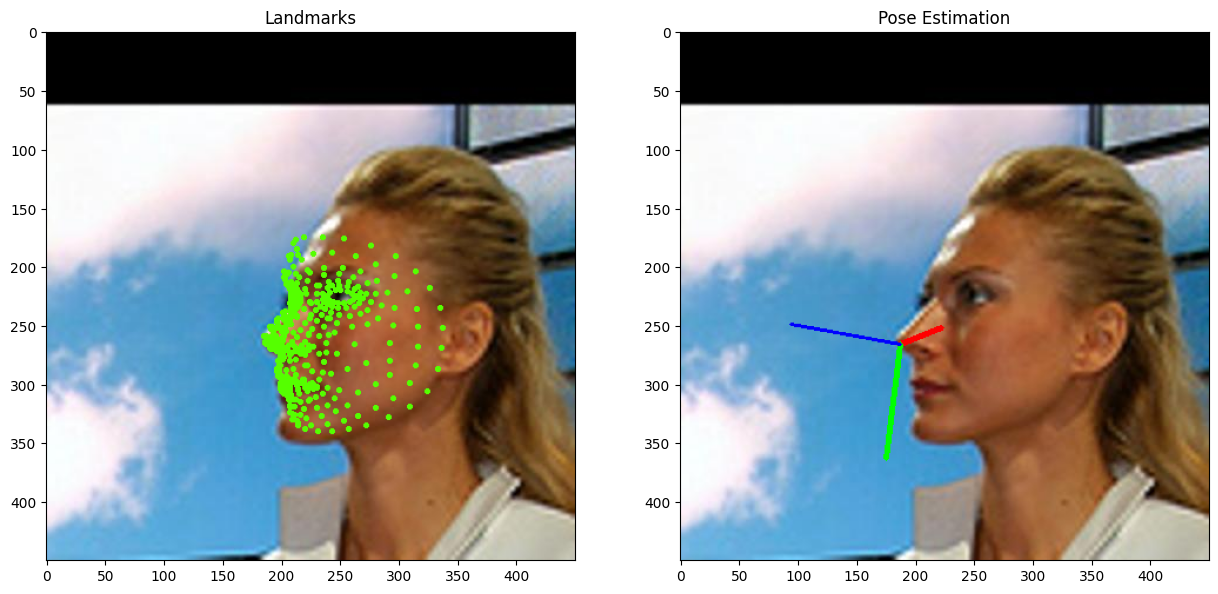

Pose parameters for image image00004.jpg: [0.47006503 1.18953335 0.30095881]


In [39]:
# Display the landmarks and pose estimation for a random image
index = 1
img = cv2.imread(data_path + img_names[index])
img_copy = img.copy()

# Draw the landmarks on the image
for relative_x, relative_y in zip(X[index], y[index]):
    cv2.circle(img_copy, (relative_x, relative_y), radius=1, color=(0, 255, 85, 200), thickness=2)

# Display the landmarks and pose estimation side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Display the landmarks
axs[0].imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
axs[0].set_title('Landmarks')

# Display the pose estimation
img_with_axis = draw_axis(img, labels[index][0], labels[index][1], labels[index][2], X[index][1], y[index][1])
axs[1].imshow(cv2.cvtColor(img_with_axis, cv2.COLOR_BGR2RGB))
axs[1].set_title('Pose Estimation')

plt.show()

print(f'Pose parameters for image {img_names[index]}: {labels[index]}')

In [27]:
print(f'X range: {X.min()} - {X.max()}')
print(f'y range: {y.min()} - {y.max()}')
print(f'Labels range: {labels.min()} - {labels.max()}')

X range: 4 - 488
y range: -26 - 429
Labels range: -16.969362258911133 - 15.598819732666016


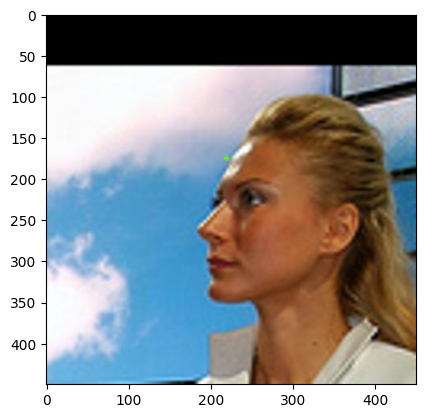

In [48]:
img = cv2.imread(data_path + img_names[index])
cv2.circle(img, (X[index][1], y[index][1]), radius=1, color=(0, 255, 85, 200), thickness=4)
cv2.circle(img, (X[index][10], y[index][10]), radius=1, color=(0, 255, 85, 200), thickness=4)   
cv2.circle(img, (X[index][171], y[index][171]), radius=1, color=(0, 255, 85, 200), thickness=4) 

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [50]:
# Normalization
X_nose_centered = X - X[:, 1][:, np.newaxis]
y_nose_centered = y - y[:, 1][:, np.newaxis]

# Calculate the distance between the chin and the head
X_chin = X[:, 171]; y_chin = y[:, 171]
X_head = X[:, 10]; y_head = y[:, 10]

distance = np.linalg.norm(np.array((X_head, y_head)) - np.array((X_chin, y_chin)), axis=0).reshape(-1, 1)

# Normalize the landmarks
X_norm = X_nose_centered / distance
y_norm = y_nose_centered / distance

features = np.hstack((X_norm, y_norm))

print('X_norm shape:{}'.format(X_norm.shape))
print('y_norm shape:{}'.format(y_norm.shape))
print('features shape:{}'.format(features.shape))
print('Features range: {} - {}'.format(features.min(), features.max()))

X_norm shape:(1853, 468)
y_norm shape:(1853, 468)
features shape:(1853, 936)
Features range: -1.0061048346297883 - 1.05004714400665


In [51]:
# Save the normalized features to a .npz file
np.savez('../data/features.npz', features=features)

# Load the normalized features
# features = np.load('../data/features.npz')['features']

In [54]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.15, random_state=42, shuffle=True)

In [83]:
# Define evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predict on training data
    train_predictions = model.predict(X_train)
    
    # Predict on test data
    predictions = model.predict(X_test)
    
    # Calculate Mean Squared Error for training and test data
    train_MSE = mean_squared_error(y_train, train_predictions)
    test_MSE = mean_squared_error(y_test, predictions)

    # Print the results in a table format with equal spacing
    print(f'{"Metric":<10}{"Train":<10}{"Test":<10}')
    print(f'{"MSE":<10}{train_MSE:<10.6f}{test_MSE:<10.6f}')
    print(f'{"RMSE":<10}{np.sqrt(train_MSE):<10.6f}{np.sqrt(test_MSE):<20.6f}')

    return train_MSE, test_MSE

### Modle 1: `SVR`

In [195]:
model_1 = MultiOutputRegressor(SVR())
model_1.fit(X_train, y_train)
result_1 = evaluate_model(model_1, X_train, y_train, X_test, y_test)

Metric    Train     Test      
MSE       0.221769  0.018557  
RMSE      0.470924  0.136224            


### Modle 2: `RandomForestRegressor`

In [196]:
model_2 = RandomForestRegressor()
model_2.fit(X_train, y_train)
result_2 = evaluate_model(model_2, X_train, y_train, X_test, y_test)

Metric    Train     Test      
MSE       0.035598  0.166467  
RMSE      0.188673  0.408004            


### Modle 3: `AdaBoostRegressor`

In [197]:
model_3 = MultiOutputRegressor(AdaBoostRegressor())
model_3.fit(X_train, y_train)
result_3 = evaluate_model(model_3, X_train, y_train, X_test, y_test)

Metric    Train     Test      
MSE       0.037888  0.618828  
RMSE      0.194650  0.786656            


### Modle 4: `GradientBoostingRegressor`

In [199]:
model_4 = MultiOutputRegressor(GradientBoostingRegressor())
model_4.fit(X_train, y_train)
result_4 = evaluate_model(model_4, X_train, y_train, X_test, y_test)

Metric    Train     Test      
MSE       0.006616  0.368512  
RMSE      0.081339  0.607052            


### Modle 5: `Dense Neural Network`

In [193]:
# Define the model
model_5 = Sequential([
    Input(shape=(features.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(3)  # Output layer with 3 units for pitch, yaw, and roll
])

# Compile the model
model_5.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model_5.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2,
    verbose=0
)

# Evaluate the model
loss, mae = model_5.evaluate(X_test, y_test, verbose=0)
print(f'Test MAE: {mae}')

result_5 = evaluate_model(model_5, X_train, y_train, X_test, y_test)

Test MAE: 0.0814160704612732
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Metric    Train     Test      
MSE       0.234139  0.021342  
RMSE      0.483879  0.146088            


In [ ]:
# save the model
model_5.save('../models/model_5.keras')

# save the model as pickle
with open('../models/model_5.pkl', 'wb') as file:
    pickle.dump(model_5, file)

# save the history in npz file
np.savez('../models/model_5_history.npz', history=history.history)

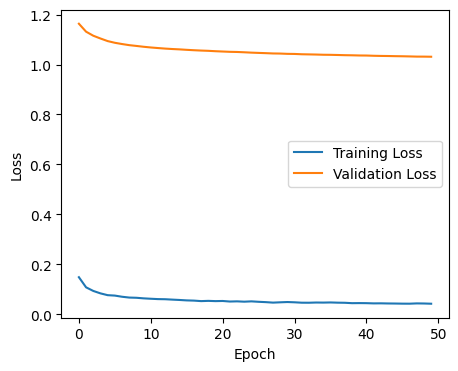

In [205]:
# Plot the training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Model Comparision

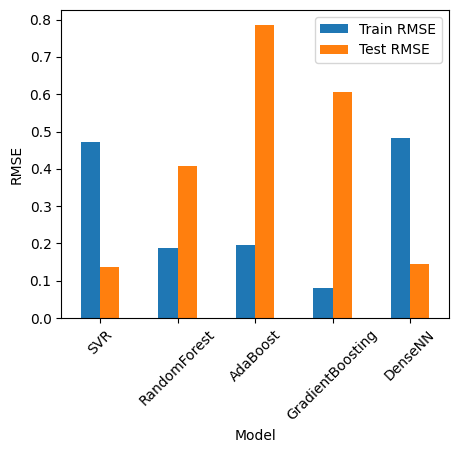

In [208]:
# Extract the MSE and RMSE values for each model
models = ['SVR', 'RandomForest', 'AdaBoost', 'GradientBoosting', 'DenseNN']
train_mse = [result_1[0], result_2[0], result_3[0], result_4[0], result_5[0]]
test_mse = [result_1[1], result_2[1], result_3[1], result_4[1], result_5[1]]
train_rmse = [np.sqrt(mse) for mse in train_mse]
test_rmse = [np.sqrt(mse) for mse in test_mse]

# Create a DataFrame for easier plotting
results_df = pd.DataFrame({
    'Model': models,
    'Train MSE': train_mse,
    'Test MSE': test_mse,
    'Train RMSE': train_rmse,
    'Test RMSE': test_rmse
})
# Plot the RMSE
results_df.plot(x='Model', y=['Train RMSE', 'Test RMSE'], kind='bar', figsize=(5, 4))
# plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(loc='upper right')

plt.show()

## Model Optimization

In [152]:
# Define the models for each pose parameter
label_names = ['pitch', 'yaw', 'roll'] 

### Optimization of `SVR`

In [128]:
# Define the SVR models for each pose parameter
svr_list = model_1.estimators_

# Evaluate each model
for i, model in enumerate(svr_list):
    print(f'\nModel for {label_names[i]}:')
    evaluate_model(model, X_train, y_train[:, i], X_test, y_test[:, i])


Model for pitch:
Metric    Train     Test      
MSE       0.282273  0.020962  
RMSE      0.531294  0.144782            

Model for yaw:
Metric    Train     Test      
MSE       0.048413  0.016220  
RMSE      0.220030  0.127359            

Model for roll:
Metric    Train     Test      
MSE       0.334621  0.018489  
RMSE      0.578464  0.135975            


In [124]:
# Function that optimizes the svr models
def svr_grid_search(X_train, y_train, params):
    # Creat SVR model
    svr = SVR()

    # Create GridSearchCV
    grid_search = GridSearchCV(
        svr, 
        params, 
        cv=5, 
        verbose=1, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1
    ) 

    # Fit the model perform the grid search
    grid_search.fit(X_train, y_train)

    # Get best model and best patameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Print best parameters
    print(f'Best parameters: {best_params}')

    return best_model, best_params

In [ ]:
params = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [1, 0.1, 0.01],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf','poly', 'linear']
}

# Optimize the SVR models
best_models = []
best_params = []

for i, model in enumerate(svr_list):
    print(f'\nOptimizing model for {label_names[i]}:')
    best_model, best_param = svr_grid_search(X_train, y_train[:, i], params)
    best_models.append(best_model)
    best_params.append(best_param)

# Evaluate the optimized models
for i, model in enumerate(best_models):
    print(f'\nOptimized model for {label_names[i]}:')
    evaluate_model(model, X_train, y_train[:, i], X_test, y_test[:, i])


In [120]:
model_1_best = best_models # [pich, yaw, roll]

# Save the best models to a .pkl file
with open('../models/model_1_svm_best.pkl', 'wb') as f:
    pickle.dump(model_1_best, f)

# Save the best parameters to npz file
np.savez('../models/model_1_svm_best_params.npz', best_params=best_params)

### Optimization of `GradientBoosting`

In [129]:
# Define the models for each pose parameter
gbr_list = model_4.estimators_

# Evaluate each model
for i, model in enumerate(gbr_list):
    print(f'\nModel for {label_names[i]}:')
    evaluate_model(model, X_train, y_train[:, i], X_test, y_test[:, i])
    


Model for pitch:
Metric    Train     Test      
MSE       0.008748  0.092984  
RMSE      0.093532  0.304933            

Model for yaw:
Metric    Train     Test      
MSE       0.006024  0.028895  
RMSE      0.077616  0.169987            

Model for roll:
Metric    Train     Test      
MSE       0.005076  0.979144  
RMSE      0.071243  0.989517            


In [130]:
# Function that optimizes the Gradient Boosting Regressor models
def gbr_grid_search(X_train, y_train, params):
    # Create Gradient Boosting Regressor model
    gbr = GradientBoostingRegressor()

    # Create GridSearchCV
    grid_search = GridSearchCV(
        gbr, 
        params, 
        cv=5, 
        verbose=1, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1
    ) 

    # Fit the model and perform the grid search
    grid_search.fit(X_train, y_train)

    # Get best model and best parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Print best parameters
    print(f'Best parameters: {best_params}')

    return best_model, best_params

In [ ]:
# Define the parameter grid for Gradient Boosting Regressor
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Optimize the Gradient Boosting Regressor models
best_models = []
best_params = []

for i, model in enumerate(model_4.estimators_):
    print(f'\nOptimizing model for {label_names[i]}:')
    best_model, best_param = gbr_grid_search(X_train, y_train[:, i], params)
    best_models.append(best_model)
    best_params.append(best_param)

# Evaluate the optimized models
for i, model in enumerate(best_models):
    print(f'\nOptimized model for {label_names[i]}:')
    evaluate_model(model, X_train, y_train[:, i], X_test, y_test[:, i])

In [171]:
model_4_best = model_4 # best_models # [pitch, yaw, roll]

# Save the best models to a .pkl file
with open('../models/model_4_gbr_best.pkl', 'wb') as f:
    pickle.dump(model_4_best, f)

# Save the best parameters to npz file
np.savez('../models/model_4_gbr_best_params.npz', best_params=best_params)

# Prediction: Uploads

In [165]:
def detect_landmarks(img):
    """
    Detects facial landmarks in the image using MediaPipe FaceMesh.
    """
    face_module = mp.solutions.face_mesh
    X = []
    y = []

    with face_module.FaceMesh(static_image_mode=True) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                shape = img.shape
                for landmark in face_landmarks.landmark:
                    relative_x = int(landmark.x * shape[1])
                    relative_y = int(landmark.y * shape[0])
                    X.append(relative_x)
                    y.append(relative_y)

    X = np.array([X])
    y = np.array([y])

    # Normalize features
    Nose_centered_X = X - X[:, 1].reshape(-1, 1)
    Nose_centered_y = y - y[:, 1].reshape(-1, 1)

    X_171 = X[:, 171]
    X_10 = X[:, 10]
    y_171 = y[:, 171]
    y_10 = y[:, 10]
    distance = np.linalg.norm(np.array((X_10, y_10)) - np.array((X_171, y_171)), axis=0).reshape(-1, 1)
    Norm_X = Nose_centered_X / distance
    Norm_Y = Nose_centered_y / distance

    nose_x = X[:, 1]
    nose_y = y[:, 1]

    features = np.hstack([Norm_X, Norm_Y])

    return features, nose_x, nose_y

def model_predict(pitch_model, yaw_model, roll_model, features):
    """
    Predicts pitch, yaw, and roll angles using the provided models.
    """
    pitch = pitch_model.predict(features)
    yaw = yaw_model.predict(features)
    roll = roll_model.predict(features)
    return pitch, yaw, roll

def perform_prediction(pitch_model, yaw_model, roll_model, img):
    """
    Performs the full prediction pipeline: detects landmarks, predicts angles, and draws the axis.
    """
    features, nose_x, nose_y = detect_landmarks(img)
    pitch, yaw, roll = model_predict(pitch_model, yaw_model, roll_model, features)
    frame = draw_axis(img, pitch, yaw, roll, nose_x.item(), nose_y.item())
    return frame

### Prediction via `Regressors`

In [209]:
# SVR models
pitch_model = model_1_best[0]
yaw_model = model_1_best[1]
roll_model = model_1_best[2]

In [174]:
# GBR models
pitch_model = model_4.estimators_[0]
yaw_model = model_4.estimators_[1]
roll_model = model_4.estimators_[2]

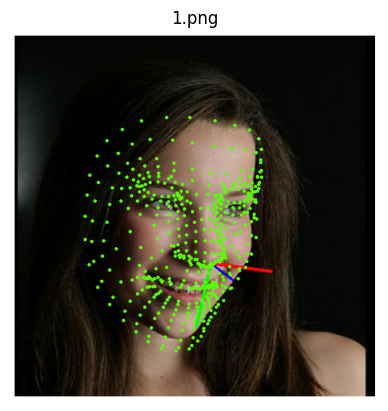

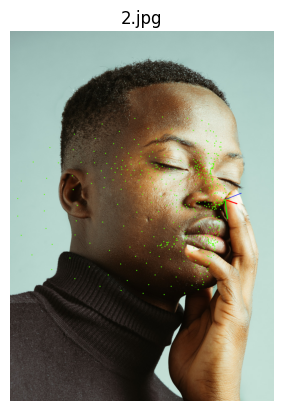

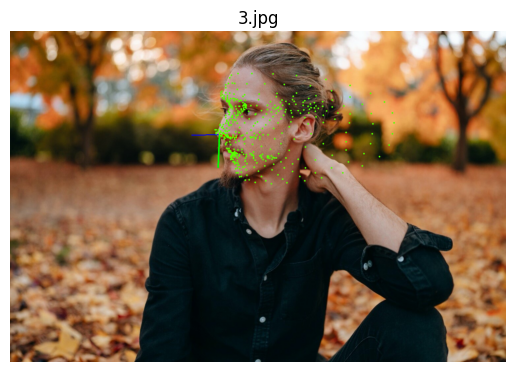

In [175]:

test_images = '../assets/test_images/'

for image_name in os.listdir(test_images):
    img = cv2.imread(test_images + image_name)
    features, nose_x, nose_y = detect_landmarks(img)
    result_img = perform_prediction(pitch_model, yaw_model, roll_model, img)
    
    # Draw the landmarks with a faint color
    for x, y in zip(features[0][:468], features[0][468:]):
        cv2.circle(result_img, (int(x * nose_x[0] + nose_x[0]), int(y * nose_y[0] + nose_y[0])), radius=1, color=(0, 255, 85, 50), thickness=2)
    
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(image_name)
    plt.axis('off')
    plt.show()

### Prediction via `DenseNN`

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


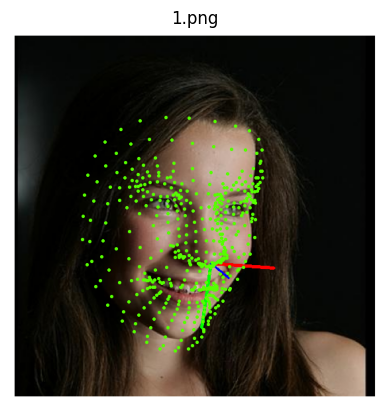

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


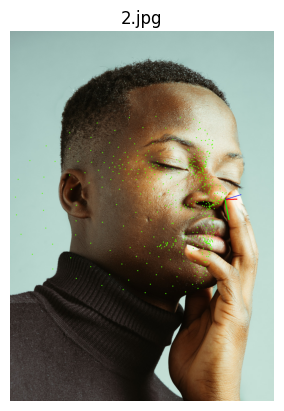

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


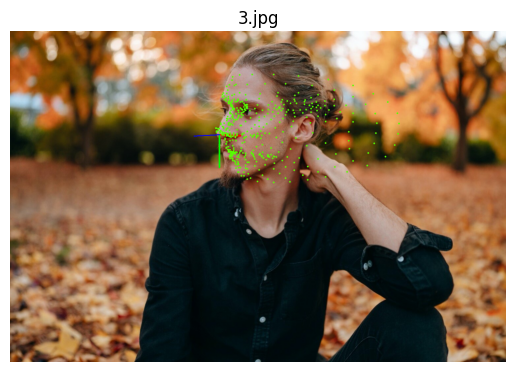

In [176]:
def model_predict_dense(model, features):
    """
    Predicts pitch, yaw, and roll angles using the provided Dense Neural Network model.
    """
    predictions = model.predict(features)
    pitch, yaw, roll = predictions[:, 0], predictions[:, 1], predictions[:, 2]
    return pitch, yaw, roll

def perform_prediction_dense(model, img):
    """
    Performs the full prediction pipeline: detects landmarks, predicts angles, and draws the axis.
    """
    features, nose_x, nose_y = detect_landmarks(img)
    pitch, yaw, roll = model_predict_dense(model, features)
    frame = draw_axis(img, pitch, yaw, roll, nose_x.item(), nose_y.item())
    return frame

# Test the Dense Neural Network model
for image_name in os.listdir(test_images):
    img = cv2.imread(test_images + image_name)
    result_img = perform_prediction_dense(model_5, img)
    
    # Draw the landmarks with a faint color
    features, nose_x, nose_y = detect_landmarks(img)
    for x, y in zip(features[0][:468], features[0][468:]):
        cv2.circle(result_img, (int(x * nose_x[0] + nose_x[0]), int(y * nose_y[0] + nose_y[0])), radius=1, color=(0, 255, 85, 50), thickness=2)
    
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(image_name)
    plt.axis('off')
    plt.show()

# Prediction: Video

# Prediction: Webcam

In [218]:
cap = cv2.VideoCapture(0)

Selected_model = 'SVR'

# Initialize variables to calculate FPS
prev_frame_time = 0
new_frame_time = 0

while True:
    try:
        # Read the next frame from the video
        ret, frame = cap.read()
        if not ret:
            break

        # Calculate FPS
        new_frame_time = cv2.getTickCount()
        fps = cv2.getTickFrequency() / (new_frame_time - prev_frame_time)
        prev_frame_time = new_frame_time

        if Selected_model == 'SVR':
            frame = perform_prediction(pitch_model, yaw_model, roll_model, frame)
        elif Selected_model == 'DenseNN':
            frame = perform_prediction_dense(model_5, frame)

        # Detect landmarks
        face_module = mp.solutions.face_mesh
        with face_module.FaceMesh(static_image_mode=False, max_num_faces=1) as face_mesh:
            results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    for landmark in face_landmarks.landmark:
                        x = int(landmark.x * frame.shape[1])
                        y = int(landmark.y * frame.shape[0])
                        cv2.circle(frame, (x, y), radius=1, color=(200, 200, 200, 50), thickness=1)

        # Display the FPS on the frame
        cv2.putText(frame, f'FPS: {int(fps)}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Display the frame
        cv2.imshow('Camera', frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) == ord('q'):
            break
    except Exception as e:
        print(f"Error: {e}")
        pass

# Release the video capture and close cv2 windows
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Test the Dense Neural Network model
for image_name in os.listdir(test_images):
    img = cv2.imread(test_images + image_name)
    result_img = perform_prediction_dense(model_5, img)
    
    # Draw the landmarks with a faint color
    features, nose_x, nose_y = detect_landmarks(img)
    for x, y in zip(features[0][:468], features[0][468:]):
        cv2.circle(result_img, (int(x * nose_x[0] + nose_x[0]), int(y * nose_y[0] + nose_y[0])), radius=1, color=(0, 255, 85, 50), thickness=2)
    
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(image_name)
    plt.axis('off')
    plt.show()